In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
import random as rand

np.random.seed(3)

#matplotlib inline

plot_size   = 15
plot_width  = 16
plot_height = 8

params = {'legend.fontsize': 'large',
          'figure.figsize': (plot_width,plot_height),
          'axes.labelsize': plot_size,
          'axes.titlesize': plot_size,
          'xtick.labelsize': plot_size*0.75,
          'ytick.labelsize': plot_size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)
plt.rcParams.update(params)
num_debot=3

num_clients = 150
num_cities = num_clients+num_debot
num_vehicles = 5
vehicle_payload = 100
debots=[0,1,2]
center_box = (100, 200) 

Vehicle_Debot=[]
#cities_coord, _ = make_blobs(n_samples=num_cities, centers=2, cluster_std=100, center_box=center_box, random_state = 2)
#print(cities_coord)
cities_coord=[]
f=pd.read_csv('E:/arshad/رایانش تکاملی/ECHW4_dataset/P1-2.txt')
x=[]
y=[]
number=[]
demand=[]
demand.append(0)
demand.append(0)
demand.append(0)
for i in f['number x y demand']:
    li=i.split(' ')
    number.append(int(li[0]))
    x.append(int(li[1]))
    y.append(int(li[2]))
    demand.append(int(li[3]))
debotcord=[] 
#Set debot location
ltemp=[]    
ltemp.append(31)
ltemp.append(6)
cities_coord.append(ltemp)
debotcord.append(ltemp)

ltemp=[]    
ltemp.append(-31)
ltemp.append(7)
cities_coord.append(ltemp)
debotcord.append(ltemp)

ltemp=[]    
ltemp.append(25)
ltemp.append(-10)
cities_coord.append(ltemp)
debotcord.append(ltemp)


for i in range(len(x)):
    ltemp=[]
    ltemp.append(x[i])
    ltemp.append(y[i])
    cities_coord.append(ltemp)

cities_coord=tuple(cities_coord)
lcx=[]
lcy=[]
for i in range(1,num_cities):
    lcx.append(cities_coord[i][0])
    lcy.append(cities_coord[i][1])
dbx=[]
dby=[]
for i in debotcord:
    dbx.append(i[0])
    dby.append(i[1])
     
all_names = [i for i in range(num_cities)]
client_names = [i for i in range(num_debot, num_cities)]
all_coord_dict = {name: coord for name,coord in zip(all_names, cities_coord)}
client_coord_dict = {name: coord for name,coord in zip(client_names, cities_coord[1:])}

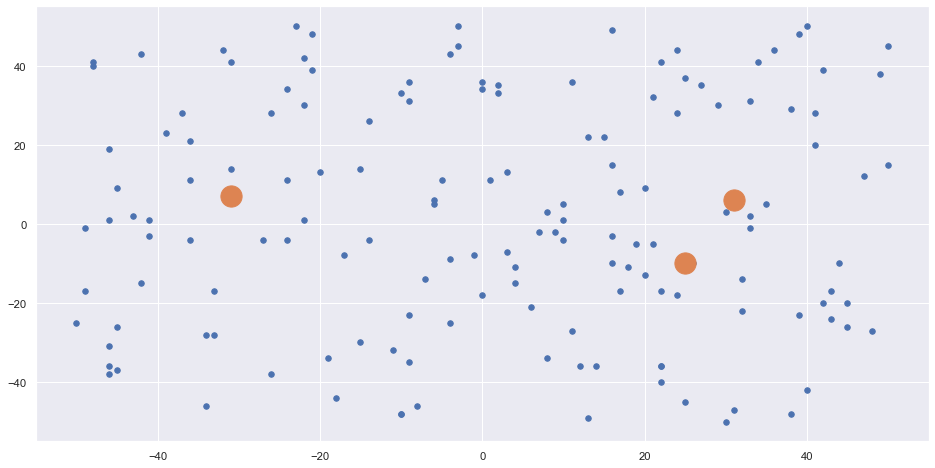

In [2]:
plt.scatter(lcx, lcy, s=plot_size*2, cmap='viridis');
plt.scatter(dbx, dby, s=plot_size*30, cmap='viridis');

In [3]:
from scipy.spatial import distance

dist_matrix = distance.cdist(cities_coord, cities_coord, 'cityblock')

from deap import base, creator, tools

tb = base.Toolbox()

creator.create('Fitness_Func', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.Fitness_Func)

import copy

def chromo_create(_cities_names):
    schedule = copy.deepcopy(_cities_names)
    vehicle = list(np.random.randint(num_vehicles, size=(len(schedule))))
    np.random.shuffle(schedule)
    chromo = [schedule, vehicle]
    
    return chromo

In [4]:
def sum1(l):
    s=0
    for i in l:
        s+=demand[i]
    return s

In [5]:
def chromo_eval(_dist_matrix, _chromo):
    #print(_chromo)
    ctemp=_chromo
    Vehicle_Debot=[]
    route_set = [[] for _ in range(num_vehicles)]
    for s, v in zip(_chromo[0], _chromo[1]):
        route_set[v].append(s)
    dist = 0
    for i in range(len(route_set)):
        ro , de=calc_route_cost(_dist_matrix, route_set[i])
        dist += ro
        Vehicle_Debot.append(de)
        
        
    for i in range(len(Vehicle_Debot))   :
        _chromo[0].insert(0,Vehicle_Debot[i])
        _chromo[1].insert(0,i)
        _chromo[0].append(Vehicle_Debot[i])
        _chromo[1].append(i)
        
    for i in range(len(route_set)):
        route_set[i].insert(0,Vehicle_Debot[i])
        route_set[i].append(Vehicle_Debot[i])
    for rout in route_set:
        r = [] 
        n = [] 
        k = []
        for i in range(len(rout)):
            r.append(rout[i])
            n.append(rout[i])
            if sum1(n)>vehicle_payload:
                n=[]
                del r[-1]
                i-=1
                rout.insert(i-1 , Vehicle_Debot[route_set.index(rout)])
    dist=0    
    

    
    for i in range(len(route_set)):
        dist+=calc_route_cost1(_dist_matrix, route_set[i])
    if len(_chromo)==2:
        _chromo.append(Vehicle_Debot)
        _chromo.append(route_set)
    else:
        _chromo[2]=Vehicle_Debot
        _chromo[3]=route_set
    serviced_customer = 0

    route_set_temp = [[] for _ in range(num_vehicles)]
    #print(route_set_temp)
    for s, v in zip(ctemp[0], ctemp[1]):
        route_set_temp[v].append(s)
        
    #print('aaa')
    for r in route_set_temp:
        s=0
        for i in range(len(r)):
            if r[i]==0 or r[i]==1 or r[i]==2:
                s+=1
        serviced_customer+=len(r)
        serviced_customer-=s
                #print(r[i])
        #if route_set_temp.index(r)==4:
            #if serviced_customer>150:
                #print('kkk')
                #print(ctemp)
                #print(serviced_customer)
                #print(r)   
    #for r in route_set_temp:
        #serviced_customer+=(len(r))
        
    fitness=[dist,serviced_customer]
    
    return fitness

In [6]:
def get_route(_chromo):
    route_set = [[] for _ in range(num_vehicles)]
    for s, v in zip(_chromo[0], _chromo[1]):
        route_set[v].append(s)
    return route_set

def calc_route_cost1(_dist_matrix, _route):
    if not _route:
        return 0
    dist=0
    #dist = dist_matrix[_route[-1], k] + dist_matrix[k, _route[0]]

    for p in range(len(_route) - 1): 
        _i = _route[p]
        _j = _route[p + 1]
        dist += _dist_matrix[_i][_j]
        
    return dist

def calc_route_cost(_dist_matrix, _route):
    if not _route:
        return 0
    bestrout=np.inf
    
    bestdebot = debots[0]
    for k in debots:
        dist = dist_matrix[_route[-1], k] + dist_matrix[k, _route[0]]

        for p in range(len(_route) - 1): 
            _i = _route[p]
            _j = _route[p + 1]
            dist += _dist_matrix[_i][_j]
            
            
        if dist<bestrout :
            bestrout=dist
            bestdebot=k
            
    
    return bestrout , bestdebot

def crossover(_co1, _co2):
    _chromo1=_co1.chromosome
    _chromo2=_co2.chromosome
    cuts = get_chromo_cut()
    partial_crossover(_chromo1[0], _chromo2[0], cuts)

    cuts1 = get_chromo_cut()
    cuts2 = get_chromo_cut(cuts1[2])

    swap_genes(_chromo1[1], _chromo2[1], cuts1, cuts2)



def partial_crossover(_chromo1, _chromo2, cuts):
    
    size1 = len(_chromo1)
    size2= len(_chromo2)
    p1= [0] * size1
    p2 = [0] * size2

    for i in range(size1):
        p1[_chromo1[i] - num_debot] = i
    
    for i in range(size2):
        p2[_chromo2[i] - num_debot] = i
        
    for i in range(cuts[0], cuts[1]):
        temp1 = _chromo1[i] - num_debot
        temp2 = _chromo2[i] - num_debot
        
        _chromo1[i], _chromo1[p1[temp2]] = temp2 + num_debot, temp1 + num_debot
        _chromo2[i], _chromo2[p2[temp1]] = temp1 + num_debot, temp2 + num_debot

        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]



def get_chromo_cut(cut_range=None, mutation=False):

    if mutation:
        randrange = num_clients
    else:
        randrange = num_clients + 1

    if cut_range is None:
        cut1 = rand.randrange(randrange)
        cut2 = rand.randrange(randrange)
        if cut1 > cut2:
            tmp = cut2
            cut2 = cut1
            cut1 = tmp
        cut_range = cut2 - cut1
    else:

        cut1 = rand.randrange(num_clients + 1 - cut_range)
        cut2 = cut1 + cut_range
    return cut1, cut2, cut_range


def swap_genes(chrom1, chrom2, cuts1, cuts2):
    tmp = chrom1[cuts1[0]:cuts1[1]]
    chrom1[cuts1[0]:cuts1[1]] = chrom2[cuts2[0]:cuts2[1]]
    chrom2[cuts2[0]:cuts2[1]] = tmp

def mutation(_co):
    _chromo=_co.chromosome
    if np.random.rand() < 0.5:
        swap_gene(_chromo)
    else:
        shuffle_gene(_chromo)


def swap_gene(_chromo):
    cuts = get_chromo_cut(mutation=True)

    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]]
        _chromo[0][cuts[0]] = _chromo[0][cuts[1]]
        _chromo[0][cuts[1]] = tmp
    else:
        tmp = _chromo[1][cuts[0]]
        _chromo[1][cuts[0]] = _chromo[1][cuts[1]]
        _chromo[1][cuts[1]] = tmp


def shuffle_gene(_chromo):
    cuts = get_chromo_cut(mutation=True)

    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[0][cuts[0]:cuts[1]] = tmp
    else:
        tmp = _chromo[1][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[1][cuts[0]:cuts[1]] = tmp

In [7]:
import random
def setOffSpring(pop,prob_fitness,prob_diversity):
    offspring=[]
    for i in range(len(pop)):
        par1=random.choice(pop)
        par2=random.choice(pop)
        if par1.fitness1>=par2.fitness1 and par1.fitness2>=par2.fitness2:
            ##Maintain diversity
            p=random.random()
            if p>=0 and p<prob_diversity:
                offspring.append(par1)
            else:
                offspring.append(par2)
                
        elif par1.fitness1<=par2.fitness1 and par1.fitness2<=par2.fitness2:
            ##Maintain diversity
            p=random.random()
            if p>=0 and p<prob_diversity:
                offspring.append(par2)
            else:
                offspring.append(par1)
        elif (par1.fitness1>=par2.fitness1 and par1.fitness2<=par2.fitness2) or (par1.fitness1<=par2.fitness1 and par1.fitness2>=par2.fitness2):
            p=random.random()
            if p>=0 and p<prob_fitness:
                offspring.append(par1)
            else:
                offspring.append(par2)
    return offspring

In [8]:
class individual:
    def __init__(self,c,f1,f2):
        self.chromosome=c
        self.fitness1=f1
        self.fitness2=f2

In [9]:
def find_best_sol1(population):
    newlist = sorted(population, key=lambda x: x.fitness1, reverse=True)
    return newlist

In [10]:
def find_best_sol2(population):
    newlist = sorted(population, key=lambda x: x.fitness2, reverse=True)
    return newlist

In [11]:
tb.register('indexes', chromo_create, client_names)
tb.register('individual', tools.initIterate, creator.Individual, tb.indexes)
tb.register('population', tools.initRepeat, list, tb.individual)
tb.register('evaluate', chromo_eval, dist_matrix)
tb.register('select', tools.selTournament)
tb.register('mate', crossover)
tb.register('mutate', mutation)
#tb.register('feasibility', feasibility)

In [12]:
num_population = 100
num_generations = 500
prob_crossover = .4
prob_mutation = .6
prob_fitness=0.5
prob_diversity=0.8
#population = tb.population(n=num_population)
p=[]
for i in range(num_population):
    p.append(chromo_create(client_names))
    
population=[]   
fitness_set=[]
for chromo in p:
    fitness_set.append(chromo_eval(dist_matrix,chromo))
for i in range(num_population):
    population.append(individual(p[i],fitness_set[i][0],fitness_set[i][1]))

pop=population
best_fit_list = []
best_sol_list = []
best_sol_f1=[]
best_sol_f2=[]
best_fit_f1 = np.Inf
best_fit_f2 = 0

for gen in range(0, num_generations):
    
    if (gen % 50 == 0):
        print(f'Generation: {gen:4} | Fitness1: {best_fit_f1:.2f} | Fitness2: {best_fit_f2:.2f}' )
    #print(population[0])
    
    #offspring = tb.select(population, len(population), tournsize=3)
    #offspring = list(map(tb.clone, offspring))
    
    #print(offspring[0])
    offspring=setOffSpring(pop,prob_fitness,prob_diversity)
    
    for i in range(0,len(offspring),2):
        child1=offspring[i]
        child2=offspring[i+1]
        if np.random.random() < prob_crossover:
            tb.mate(child1, child2)
         
    for chromo in offspring:
        if np.random.random() < prob_mutation:
            tb.mutate(chromo)
    
    #invalid_ind = [ind for ind in offspring if not (ind.fitness1 == np.inf or ind.fitness2==0)]
    fitness_set=[]
    for chromo in offspring:
        fitness_set.append(chromo_eval(dist_matrix,chromo.chromosome))
    for i in range(len(offspring)):
        population.append(individual(offspring[i],fitness_set[i][0],fitness_set[i][1]))
    #fitness_set = map(tb.evaluate, invalid_ind)
    

    
    #population[:] = offspring
    fb1=find_best_sol1(population)
    curr_best_sol_f1 = fb1[0]
    curr_best_fit_f1 = curr_best_sol_f1.fitness1
    #print('curr_best_fit_f1 '+str(curr_best_fit_f1))
    fb2=find_best_sol2(population)
    curr_best_sol_f2 =fb2[0] 
    curr_best_fit_f2 = curr_best_sol_f2.fitness2
    #print('curr_best_fit_f2 '+str(curr_best_fit_f2))

    
    if curr_best_fit_f1 < best_fit_f1:
        best_fit_f1=curr_best_fit_f1
        best_sol_f1=curr_best_sol_f1
        
    if curr_best_fit_f2 > best_fit_f2 and curr_best_fit_f2 <=num_clients:
        best_fit_f2=curr_best_fit_f2
        best_sol_f2=curr_best_sol_f2

    a=[]
    a.append(best_fit_f1)
    a.append(best_fit_f2)
    b=[]
    b.append(best_sol_f1)
    b.append(best_sol_f2)
    best_fit_list.append(a)
    best_sol_list.append(b)
    population=population[0:num_population]
    pop=population
    random.shuffle(pop)


Generation:    0 | Fitness1: inf | Fitness2: 0.00
Generation:   50 | Fitness1: 12726.00 | Fitness2: 150.00
Generation:  100 | Fitness1: 12726.00 | Fitness2: 150.00
Generation:  150 | Fitness1: 12726.00 | Fitness2: 150.00
Generation:  200 | Fitness1: 12726.00 | Fitness2: 150.00
Generation:  250 | Fitness1: 12726.00 | Fitness2: 150.00
Generation:  300 | Fitness1: 12726.00 | Fitness2: 150.00
Generation:  350 | Fitness1: 12726.00 | Fitness2: 150.00
Generation:  400 | Fitness1: 12726.00 | Fitness2: 150.00
Generation:  450 | Fitness1: 12726.00 | Fitness2: 150.00


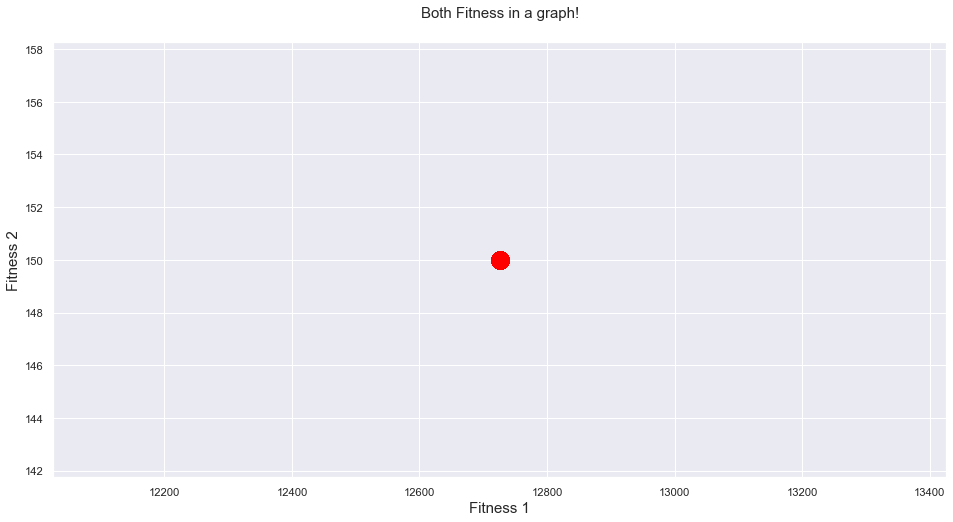

In [13]:
fit1=[]
fit2=[]
for i in range(len(best_fit_list)):
    fit1.append(best_fit_list[i][0])
    fit2.append(best_fit_list[i][1])

plt.scatter(fit1, fit2, s=plot_size*20,color='red');
  
# naming the x axis
plt.xlabel('Fitness 1')
# naming the y axis
plt.ylabel('Fitness 2')
  
# giving a title to my graph
plt.title('Both Fitness in a graph!')
  
# function to show the plot
plt.show()

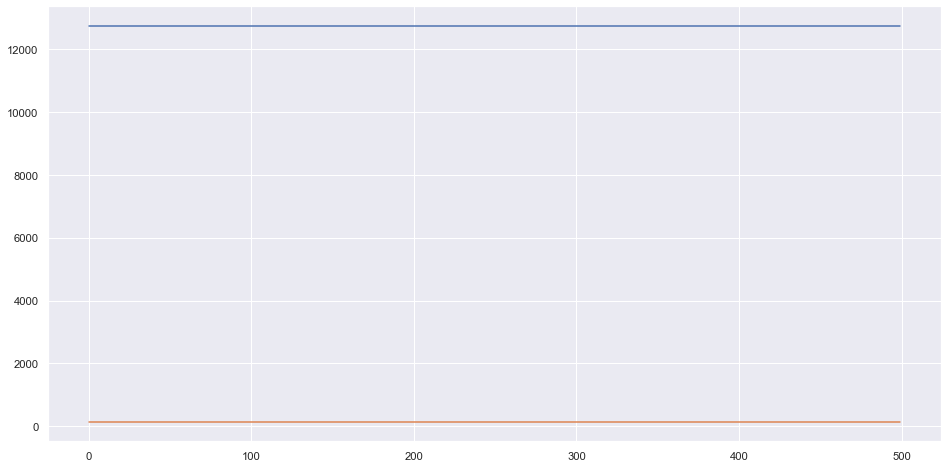

In [14]:
plt.plot(best_fit_list)
plt.show()